<a href="https://colab.research.google.com/github/Tony181189/Projeto-1/blob/main/JPMorgan_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [38]:
# Carregar os dados
df = pd.read_csv('Nat_Gas.csv')

In [39]:
df.tail()

,Dates,Prices
43,5/31/24,11.4
44,6/30/24,11.5
45,7/31/24,11.6
46,8/31/24,11.5
47,9/30/24,11.8


In [40]:
# Converter a coluna de datas para o formato datetime
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')
df = df.set_index('Dates')

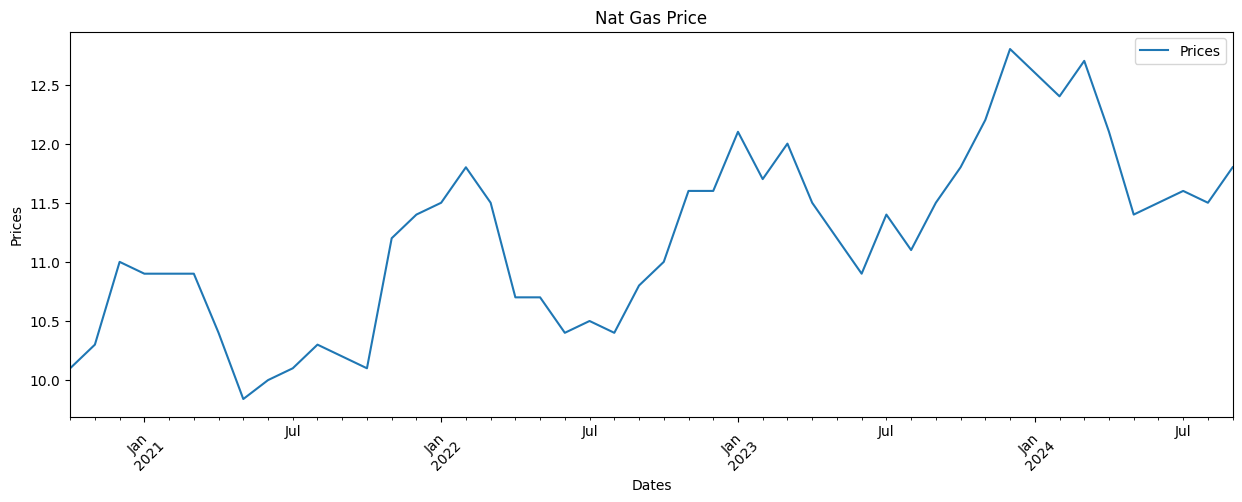

In [41]:
# Plotar os dados originais
df.plot(figsize=(15,5))
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Nat Gas Price')
plt.show()

In [42]:
# Separação dos dados de treino e teste
train_data = df[df.index < '2023-11-30']
test_data = df[df.index >= '2023-11-30']

In [43]:
# Modelo SARIMAX
modelo = SARIMAX(train_data, order=(1,1,1), seasonal_order=(1,1,1,12))
resultado = modelo.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [44]:
# Previsão para o período de teste
pred = resultado.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

In [45]:
# Extrapolação para um ano adicional
forecast = resultado.get_forecast(steps=12)
forecast_index = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean

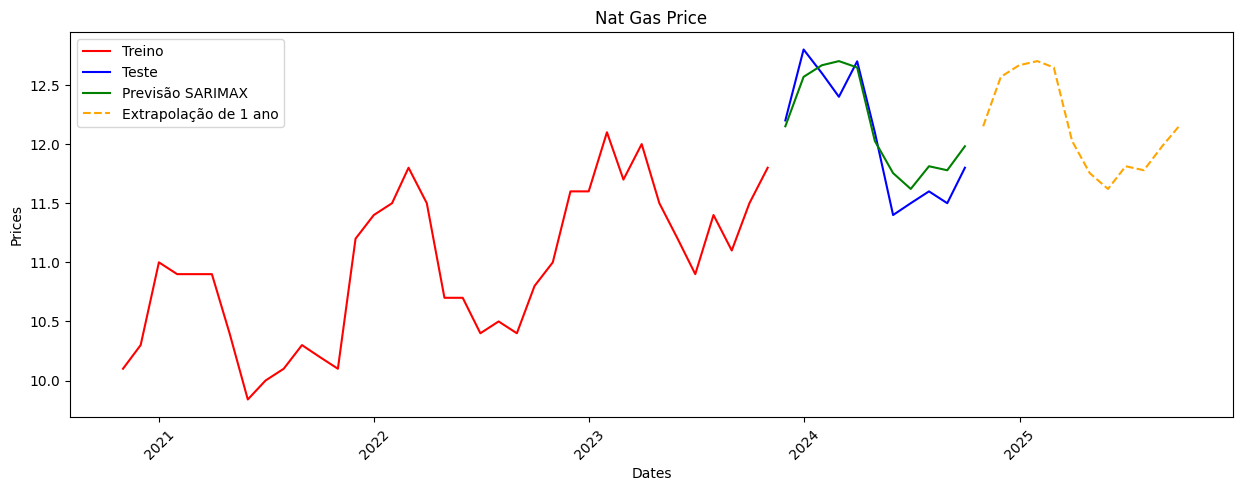

In [46]:
# Plotar os resultados
plt.figure(figsize=(15, 5))
plt.plot(train_data.index, train_data, color='red', label='Treino')
plt.plot(test_data.index, test_data, color='blue', label='Teste')
plt.plot(test_data.index, pred, color='green', label='Previsão SARIMAX')
plt.plot(forecast_index, forecast_values, color='orange', linestyle='--', label='Extrapolação de 1 ano')
plt.xticks(rotation=45)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Nat Gas Price')
plt.legend()
plt.show()

In [47]:
def estimar_preco(data, resultado, df):
    data = pd.to_datetime(data)

    # Verificar se a data está dentro do intervalo de dados disponíveis
    if data in df.index:
        # Retorna o valor numérico em vez de uma série
        return df.loc[data].item()
    else:
        steps_ahead = (data.year - df.index[-1].year) * 12 + (data.month - df.index[-1].month)

        if steps_ahead > 0:
            # Previsão para datas futuras
            forecast = resultado.get_forecast(steps=steps_ahead)
            return forecast.predicted_mean.iloc[-1]  # Retorna o valor da previsão
        else:
            # Previsão para datas passadas (retroativa)
            steps_behind = (df.index[0].year - data.year) * 12 + (df.index[0].month - data.month)
            if steps_behind > 0:
                # Inverter os dados
                inverted_df = df[::-1]
                inverted_model = SARIMAX(inverted_df, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
                inverted_resultado = inverted_model.fit()

                reversed_forecast = inverted_resultado.get_forecast(steps=steps_behind)
                return reversed_forecast.predicted_mean.iloc[-1]  # Retorna o valor retroativo
            else:
                print("Data fora do alcance do modelo.")
                return None

In [51]:
# Exemplo de uso da função
data_exemplo = '2025-09-30'
preco_estimado = estimar_preco(data_exemplo, resultado, df)
print(f'O preço estimado para {data_exemplo} é {preco_estimado:.2f}')

O preço estimado para 2025-09-30 é 12.16


In [53]:
# Exemplo de uso da função para uma data no passado
data_passada = '2010-05-31'
preco_no_passado = estimar_preco(data_passada, resultado, df)
if preco_no_passado is not None:
    print(f'O preço estimado para {data_passada} é {preco_no_passado:.2f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting 

O preço estimado para 2010-05-31 é 4.19


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
